In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import KFold

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

import function

In [ ]:
survival_data_path = '/Users/yuzimeng/Desktop/CBB/Yale/Lajos_Lab/W2_DFA&SA_on_clinic_data/placebo_both_clinic_gene_data_for_training_after_merged.csv'
lasso_file_path = './Result_Lasso_with_Multicox.xlsx'
comp_file_path = './Results_by_Groups_filtered.xlsx'
coxph_file_path = '~/Desktop/CBB/Yale/Lajos_Lab/W6_Feature_CoxPH_&_Pubs/train_test_dataset/'

y, clinical_val, survival_val, gene_exp, df_lasso, comp_result, selected_genes_lasso, selected_genes_comp = function.read_file(survival_data_path, lasso_file_path, comp_file_path)

(150, 19447) (150, 10)
(150, 3) (150, 3)
Index(['USI', 'RNA Batch', 'Treatment Arm', 'Menospausal Status', 'Age',
       'Allocation', 'Risk Group', 'IDFS Event', 'Duration of followup (days)',
       'Time to event if any (days)'],
      dtype='object')
Index(['gene_name', 'coef', 'exp(coef)', 'se(coef)', 'z', 'Pr(>|z|)',
       'p.adjusted.FDR', 'lower .95', 'upper .95'],
      dtype='object')
Available sheets: ['results_1_year_filtered', 'results_3_year_filtered', 'results_5_year_filtered']

--- Reading sheet: 'results_1_year_filtered' ---
     Gene   p_value  FoldChange  log2FoldChange
0  JCHAIN  0.003574    1.305402        0.384495
1   YPEL3  0.005964    0.813493       -0.297799
2    PIGR  0.029023    1.416144        0.501967
3    EMC6  0.030116    1.386186        0.471121
4  CITED4  0.033691    0.801070       -0.320000

--- Reading sheet: 'results_3_year_filtered' ---
     Gene   p_value  FoldChange  log2FoldChange
0  JCHAIN  0.003574    1.305402        0.384495
1   YPEL3  0.0059

#### 0. prepare scikit-survival format

X: feature, clinical variables + kept genes

(150, 7)
sparsity is totally 26.83601583791845% among matrix
sparsity is totally 0.2222222222222222% among selected genes matrix
Index(['CD24', 'SELENOP', 'ENC1', 'CCND1', 'KDM2A', 'MBOAT1', 'Age',
       'Menospausal Status_Pre-Menopausal', 'Risk Group_2.0', 'Risk Group_3.0',
       'Risk Group_4.0'],
      dtype='object')
(150, 8)
sparsity is totally 26.83601583791845% among matrix
sparsity is totally 6.476190476190475% among selected genes matrix
Index(['JCHAIN', 'YPEL3', 'PIGR', 'EMC6', 'CITED4', 'C6orf141', 'TPSB2', 'Age',
       'Menospausal Status_Pre-Menopausal', 'Risk Group_2.0', 'Risk Group_3.0',
       'Risk Group_4.0'],
      dtype='object')
log-rank test for survival curve
log-rank test statistic, p-value: (np.float64(0.015335970039748107), np.float64(0.9014431607585323))
--- training set distribution ---
[81 24]
False: 81, True: 24
event(happen) rate: 22.86%

--- testing set distribution ---
[35 10]
False: 35, True: 10
event(happen) rate: 22.86%


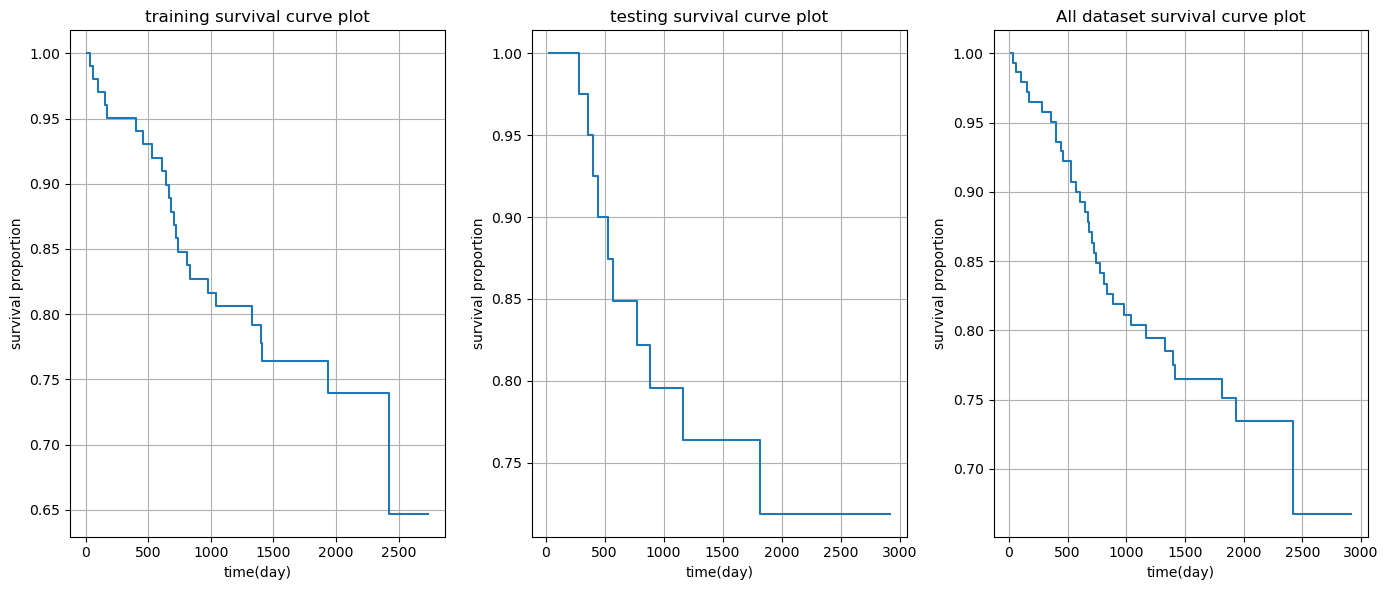

log-rank test for survival curve
log-rank test statistic, p-value: (np.float64(0.015335970039748107), np.float64(0.9014431607585323))
--- training set distribution ---
[81 24]
False: 81, True: 24
event(happen) rate: 22.86%

--- testing set distribution ---
[35 10]
False: 35, True: 10
event(happen) rate: 22.86%


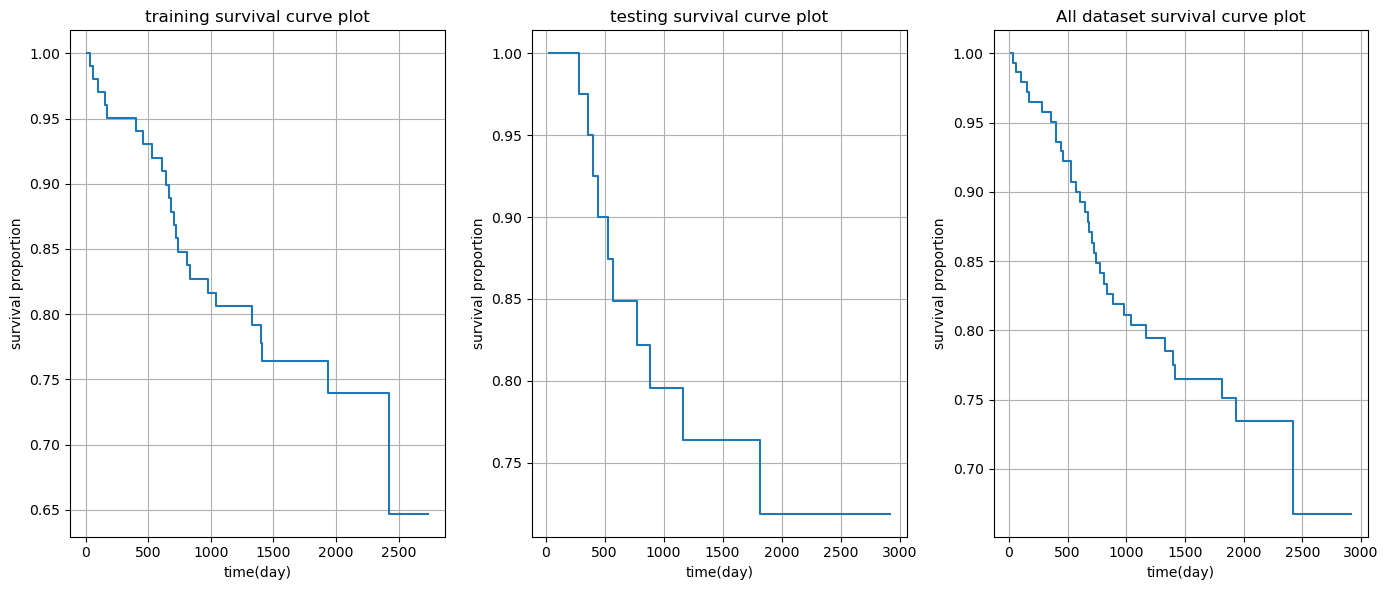

Index(['CD24', 'SELENOP', 'ENC1', 'CCND1', 'KDM2A', 'MBOAT1', 'Age',
       'Menospausal Status_Pre-Menopausal', 'Risk Group_2.0', 'Risk Group_3.0',
       'Risk Group_4.0'],
      dtype='object') Index(['JCHAIN', 'YPEL3', 'PIGR', 'EMC6', 'CITED4', 'C6orf141', 'TPSB2', 'Age',
       'Menospausal Status_Pre-Menopausal', 'Risk Group_2.0', 'Risk Group_3.0',
       'Risk Group_4.0'],
      dtype='object')


In [3]:
from sksurv.util import Surv

y_structured = Surv.from_arrays(
    event=y['IDFS Event'].values.astype(bool),
    time=y['Time to event if any (days)'].values
)

X_lasso = function.gene_exp_scale(selected_genes_lasso, clinical_val, gene_exp)
X_comp = function.gene_exp_scale(selected_genes_comp, clinical_val, gene_exp)

X_train_lasso, X_test_lasso, y_train_lasso, y_test_lasso = function.split_dataset(X_lasso, y_structured)
X_train_comp, X_test_comp, y_train_comp, y_test_comp = function.split_dataset(X_comp, y_structured)
print(X_train_lasso.columns, X_train_comp.columns)

## 0. Folded

In [4]:
# y_train_lasso = pd.DataFrame(y_train_lasso)
# y_test_lasso = pd.DataFrame(y_test_lasso)

# X_train_lasso.to_csv(f'./data/X_train_Lasso.csv', index=False)
# X_test_lasso.to_csv(f'./data/X_test_Lasso.csv', index=False)
# y_train_lasso.to_csv(f'./data/y_train_Lasso.csv', index=False)
# y_test_lasso.to_csv(f'./data/y_test_Lasso.csv', index=False)

# y_train_comp = pd.DataFrame(y_train_comp)
# y_test_comp = pd.DataFrame(y_test_comp)

# X_train_comp.to_csv(f'./data/X_train_comp.csv', index=False)
# X_test_comp.to_csv(f'./data/X_test_comp.csv', index=False)
# y_train_comp.to_csv(f'./data/y_train_comp.csv', index=False)
# y_test_comp.to_csv(f'./data/y_test_comp.csv', index=False)

In [5]:
X_lasso.to_csv(f'./data/X_Lasso.csv', index=False)
X_comp.to_csv(f'./data/X_comp.csv', index=False)

y_df = pd.DataFrame(y_structured)
y_df.to_csv(f'./data/y.csv', index=False)

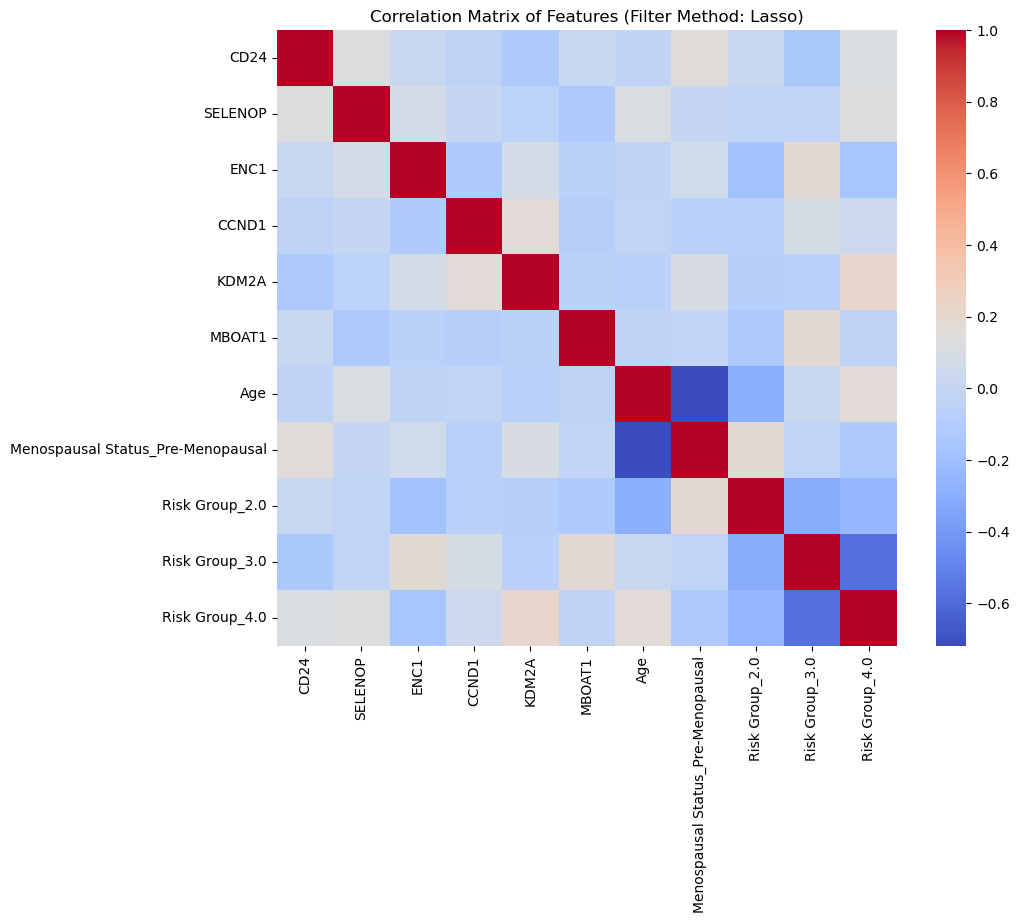

In [4]:
corr_matrix = X_train_lasso.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title('Correlation Matrix of Features (Filter Method: Lasso)')
plt.show()

high_corr_pairs = (corr_matrix.abs() > 0.9) & (corr_matrix.abs() < 1.0)
high_corr_indices = high_corr_pairs.stack()[high_corr_pairs.stack()]


## 1. Random Forest (RF)
RF is often used for classification or regression, where we use it as a classification model to predict whether an event will occur (event).

`n_estimators`: The number of trees

`random_state`: to ensure that the result can be reproduced


### 1.1 RSF for split test:train = 3:7

C-index (mean ± std): 0.5335 ± 0.1017
Time-Dependent AUC in 1825 days (mean ± std): 0.5117 ± 0.0953
Brier Score in 1825 days (mean ± std): 0.2065 ± 0.0391


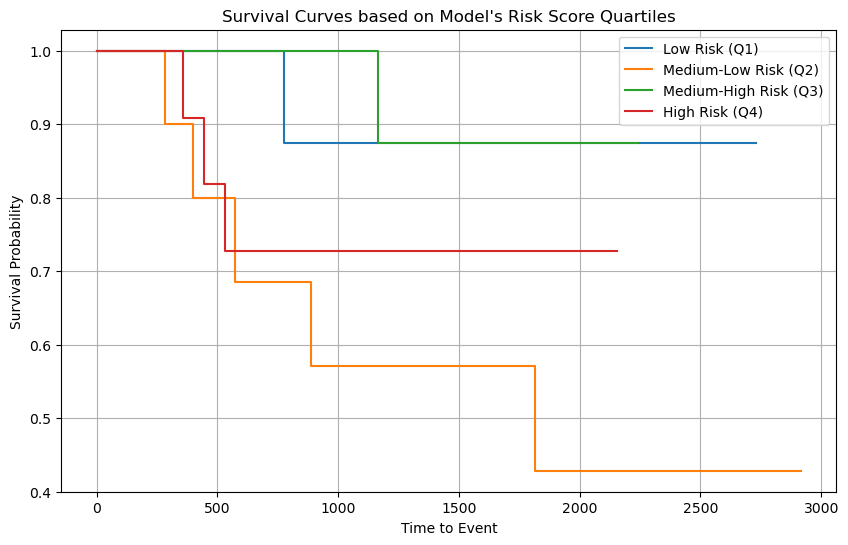

In [6]:
function.random_survival_forest_with_sd(X_train_comp, X_test_comp, y_train_comp, y_test_comp, 5)

### 1.2 RSF for all samples

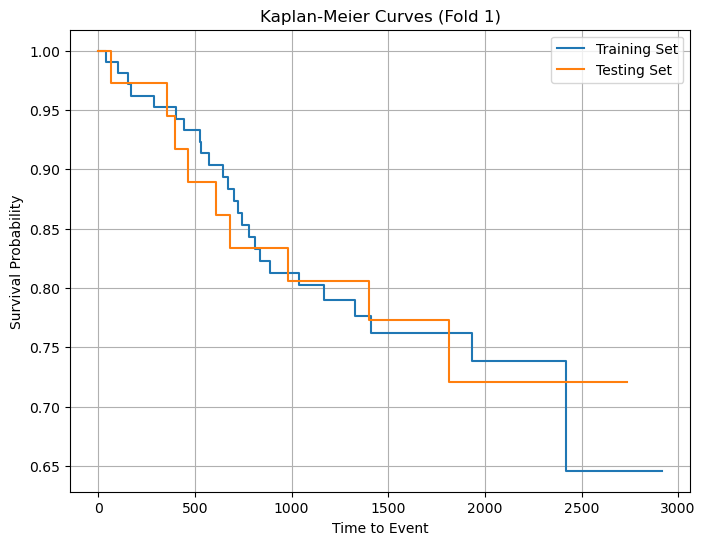

--- Fold 1 ---
Performing log-rank test for survival curve similarity...
Log-rank test statistic: 0.0000, p-value: 0.9964
The survival curves of the training and testing sets are not significantly different (p > 0.05).
------------------------------
  Training Set: Event Rate = 0.2232 (112 samples)
  Testing Set:  Event Rate = 0.2368 (38 samples)
------------------------------
c-index in 1 is 0.5916030534351145


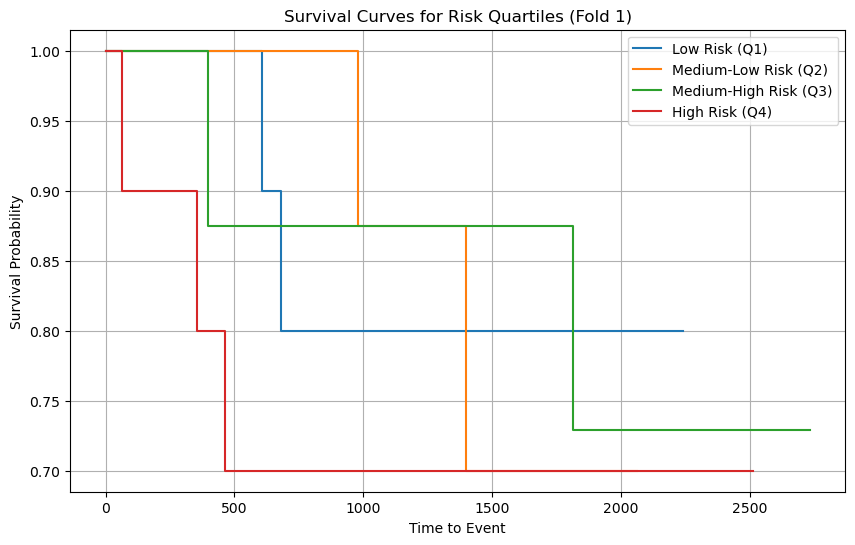

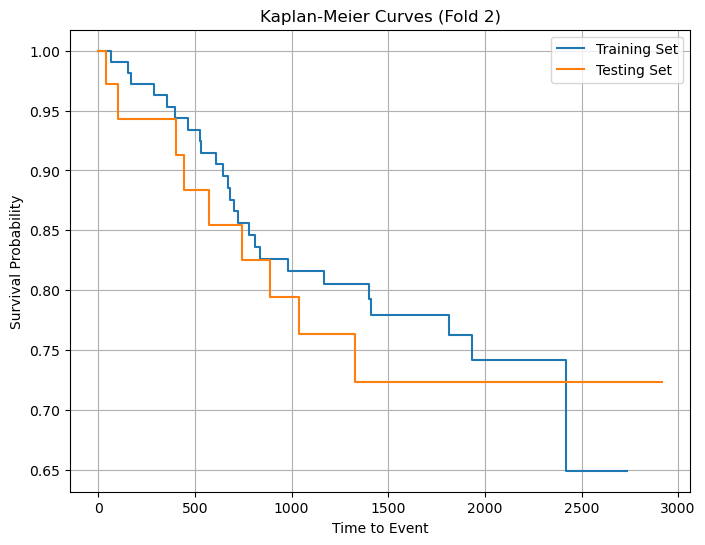

--- Fold 2 ---
Performing log-rank test for survival curve similarity...
Log-rank test statistic: 0.1875, p-value: 0.6650
The survival curves of the training and testing sets are not significantly different (p > 0.05).
------------------------------
  Training Set: Event Rate = 0.2232 (112 samples)
  Testing Set:  Event Rate = 0.2368 (38 samples)
------------------------------
c-index in 2 is 0.5905511811023622


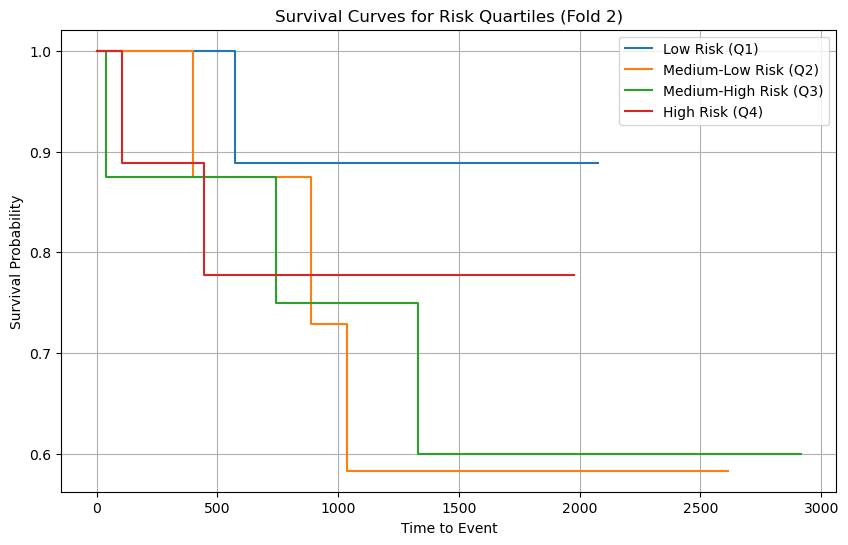

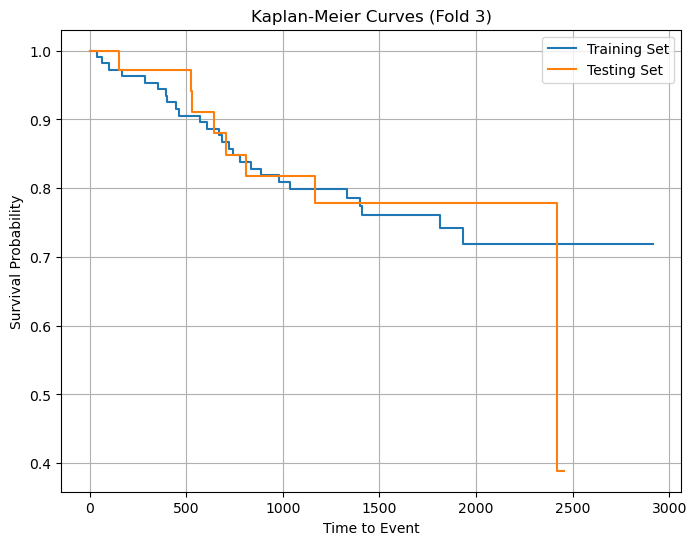

--- Fold 3 ---
Performing log-rank test for survival curve similarity...
Log-rank test statistic: 0.0060, p-value: 0.9383
The survival curves of the training and testing sets are not significantly different (p > 0.05).
------------------------------
  Training Set: Event Rate = 0.2301 (113 samples)
  Testing Set:  Event Rate = 0.2162 (37 samples)
------------------------------
c-index in 3 is 0.5858585858585859


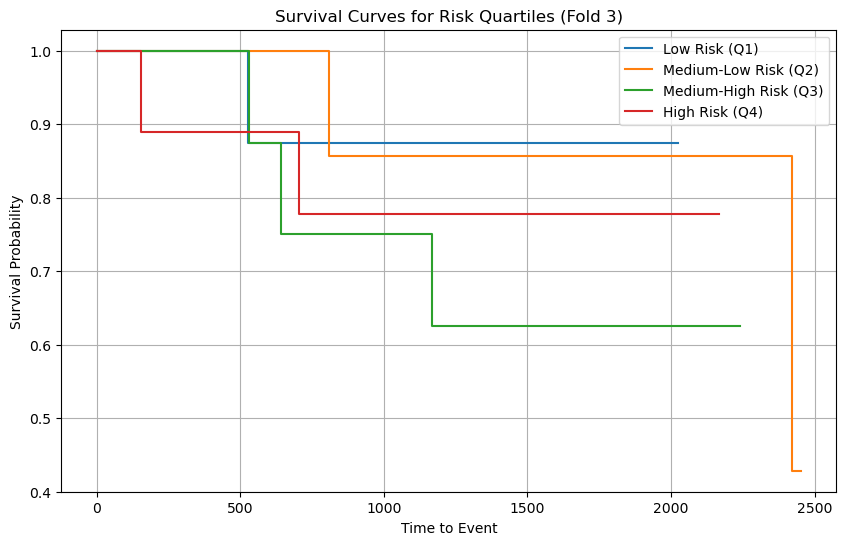

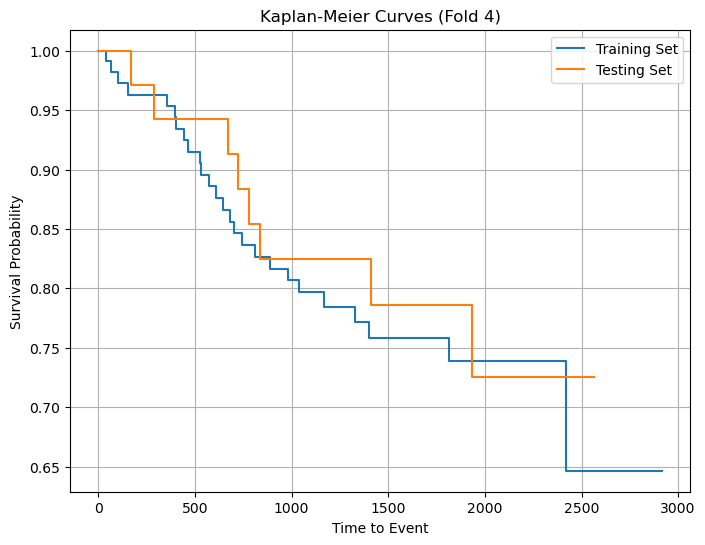

--- Fold 4 ---
Performing log-rank test for survival curve similarity...
Log-rank test statistic: 0.1135, p-value: 0.7362
The survival curves of the training and testing sets are not significantly different (p > 0.05).
------------------------------
  Training Set: Event Rate = 0.2301 (113 samples)
  Testing Set:  Event Rate = 0.2162 (37 samples)
------------------------------
c-index in 4 is 0.6221198156682027


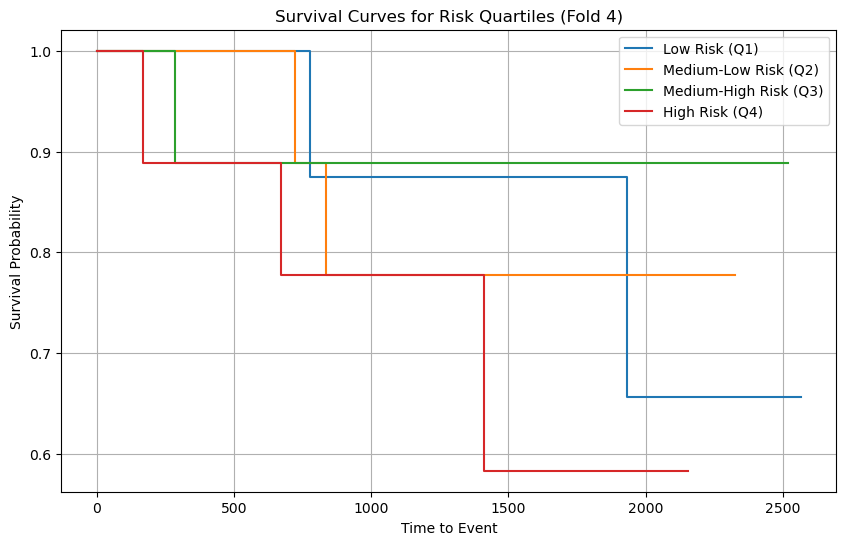

C-index for each fold: [np.float64(0.5916030534351145), np.float64(0.5905511811023622), np.float64(0.5858585858585859), np.float64(0.6221198156682027)]
Average C-index (4-fold cross-validation): 0.5975
Standard deviation of C-index: 0.0144
Time-Dependent AUC (1825 days): 0.5967 +/- 0.0376
Brier Score (1825 days): 0.1957 +/- 0.0249


In [9]:
function.random_survival_forest_for_all(X_comp, y_structured, 5, 4)

## 3.Survival Support Vector Model

Apply the principles of support vector machines (SVMs) to survival data. It aims to find a hyperplane that maximizes the difference between the time of occurrence of an event and the time of review.

[survival-SVM link](https://scikit-survival.readthedocs.io/en/latest/user_guide/survival-svm.html)

### 3.1 Survival_SVM for split test:train = 3:7

In [12]:
function.Survival_SVM_for_split(X_train_comp, X_test_comp, y_train_comp, y_test_comp, 5)

------ Running Survival SVM on a single split ------
Best alpha found: 0.25
--- Metrics for a single split ---
C-index (mean ± std): 0.5806 ± 0.0868
Time-Dependent AUC in 1825 days (mean ± std): 0.5765 ± 0.0890


### 3.2 Survival_SVM for all Samples(n=150)

In [16]:
function.Survival_SVM_for_all(X_comp, y_structured, 5, 4)

------ Running Survival SVM with 4-fold Stratified CV ------

--- Fold 1 ---
Log-rank test p-value: 0.9964
  Training Set: Event Rate = 0.2232 (112 samples)
  Testing Set:  Event Rate = 0.2368 (38 samples)
------------------------------
C-index for Fold 1: 0.6211 ± 0.1076
AUC (1825 days) for Fold 1: 0.6017 ± 0.1214

--- Fold 2 ---
Log-rank test p-value: 0.6650
  Training Set: Event Rate = 0.2232 (112 samples)
  Testing Set:  Event Rate = 0.2368 (38 samples)
------------------------------
C-index for Fold 2: 0.6510 ± 0.0992
AUC (1825 days) for Fold 2: 0.6646 ± 0.0959

--- Fold 3 ---
Log-rank test p-value: 0.9383
  Training Set: Event Rate = 0.2301 (113 samples)
  Testing Set:  Event Rate = 0.2162 (37 samples)
------------------------------
C-index for Fold 3: 0.5377 ± 0.1376
AUC (1825 days) for Fold 3: 0.5176 ± 0.1385

--- Fold 4 ---
Log-rank test p-value: 0.7362
  Training Set: Event Rate = 0.2301 (113 samples)
  Testing Set:  Event Rate = 0.2162 (37 samples)
--------------------------

## 4.XGBoost for survival version

Consists of a decision tree and is an extension of Random Forest in survival analysis. It predicts an individual's survival function by averaging the survival tree on multiple subsamples.

In [119]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis, GradientBoostingSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

### 4.1 Split

In [19]:
function.survival_xgboost_for_split(X_train_lasso, X_test_lasso, y_train_lasso, y_test_lasso, 5)

------ Running Gradient Boosting Survival Analysis on a single split ------

--- Metrics for a single split ---
C-index (mean ± std): 0.5811 ± 0.1145
Time-Dependent AUC in 1825 days (mean ± std): 0.5746 ± 0.1025
Brier Score in 1825 days (mean ± std): 0.1860 ± 0.0431


### 5.2 All Samples

In [22]:
function.survival_xgboost_for_all_sample(X_lasso, y_structured, 5, 4)

------ Running Gradient Boosting Survival Analysis with 4-fold Stratified CV ------

--- Fold 1 ---
Log-rank test p-value: 0.9964
  Training Set: Event Rate = 0.2232 (112 samples)
  Testing Set:  Event Rate = 0.2368 (38 samples)
------------------------------
C-index for Fold 1: 0.8062 ± 0.0799
AUC (1825 days) for Fold 1: 0.7654 ± 0.0837
Brier Score (1825 days) for Fold 1: 0.1871 ± 0.0514

--- Fold 2 ---
Log-rank test p-value: 0.6650
  Training Set: Event Rate = 0.2232 (112 samples)
  Testing Set:  Event Rate = 0.2368 (38 samples)
------------------------------
C-index for Fold 2: 0.6363 ± 0.0886
AUC (1825 days) for Fold 2: 0.6299 ± 0.0910
Brier Score (1825 days) for Fold 2: 0.1827 ± 0.0477

--- Fold 3 ---
Log-rank test p-value: 0.9383
  Training Set: Event Rate = 0.2301 (113 samples)
  Testing Set:  Event Rate = 0.2162 (37 samples)
------------------------------
C-index for Fold 3: 0.8444 ± 0.0687
AUC (1825 days) for Fold 3: 0.8359 ± 0.0736
Brier Score (1825 days) for Fold 3: 0.1498 ±